In [1]:
%load_ext autoreload
%autoreload 2
from openproblems.tasks.regulatory_effect_prediction import datasets, methods

## I. Use the utility function to prepare a subset of genes that are HVG and also mappable to chromosomes/TSS

In [2]:
from openproblems.patch import patch_datacache
import numpy as np
import pandas as pd
import scanpy as sc
import warnings

def _chrom_limit(x, tss_size=2e5):
    """Extend TSS to upstream and downstream intervals.

    Parameters
    ----------
    x : pd.Series
        a pd.Series containing [start, end, direction]
        where start and end are ints and direction is {'+', '-'}.
    tss_size: int
        a int that defines the upstream and downstream regions around TSS
    """
    y = x.values
    gene_direction = y[-1]
    gene_start = y[-3]
    gene_end = y[-2]
    if gene_direction == "+":
        return [gene_start - tss_size // 2, gene_start + tss_size // 2]
    else:
        return [gene_end - tss_size // 2, gene_end + tss_size // 2]


def _get_annotation(adata, retries=3):
    """Insert meta data into adata.obs."""
    from pyensembl import EnsemblRelease

    data = EnsemblRelease(
        adata.uns["release"],
        adata.uns["species"],
    )
    for _ in range(retries):
        try:
            with patch_datacache():
                data.download(overwrite=False)
                data.index(overwrite=False)
            break
        except TimeoutError:
            pass

    # get ensemble gene coordinate
    genes = []
    for i in adata.var.index.map(lambda x: x.split(".")[0]):
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    action="ignore", message="No results found for query"
                )
                gene = data.gene_by_id(i)
            genes.append(
                [
                    "chr%s" % gene.contig,
                    gene.start,
                    gene.end,
                    gene.strand,
                    gene.exons
                ]
            )
        except ValueError:
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings(
                        action="ignore", message="No results found for query"
                    )
                    i = data.gene_ids_of_gene_name(i)[0]
                gene = data.gene_by_id(i)
                genes.append(
                    [
                        "chr%s" % gene.contig,
                        gene.start,
                        gene.end,
                        gene.strand,
                        gene.exons                        
                    ]
                )
            except (IndexError, ValueError) as e:
                # print(e)
                genes.append([np.nan, np.nan, np.nan, np.nan])
    old_col = adata.var.columns.values
    adata.var = pd.concat(
        [adata.var, pd.DataFrame(genes, index=adata.var_names)], axis=1
    )
    adata.var.columns = np.hstack(
        [old_col, np.array(["chr", "start", "end", "strand", 'exons'])]
    )


def _filter_mitochondrial(adata):
    if adata.uns["species"] in ["mus_musculus", "homo_sapiens"]:
        adata.var["mt"] = adata.var.gene_short_name.str.lower().str.startswith(
            "mt-"
        )  # annotate the group of mitochondrial genes as 'mt'
        sc.pp.calculate_qc_metrics(
            adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
        )

        adata_filter = adata[adata.obs.pct_counts_mt <= 10]
        if adata_filter.shape[0] > 100:
            adata = adata_filter.copy()
    return adata


def _filter_n_genes_max(adata):
    adata_filter = adata[adata.obs.n_genes_by_counts <= 2000]
    if adata_filter.shape[0] > 100:
        adata = adata_filter.copy()
    return adata


def _filter_n_genes_min(adata):
    adata_filter = adata.copy()
    sc.pp.filter_cells(adata_filter, min_genes=200)
    if adata_filter.shape[0] > 100:
        adata = adata_filter
    return adata


def _filter_n_cells(adata):
    adata_filter = adata.copy()
    sc.pp.filter_genes(adata_filter, min_cells=5)
    if adata_filter.shape[1] > 100:
        adata = adata_filter
    return adata


def _filter_has_chr(adata):
    adata_filter = adata[:, ~pd.isnull(adata.var.loc[:, "chr"])].copy()
    if adata_filter.shape[1] > 100:
        adata = adata_filter
    return adata

**This step takes like five minutes for the whole object. Please wait.**
## In the context of testing, the pre-analysis here check for genes that are
i. Highly variable.
ii. Chromosome+exons mappable.

In [3]:
# test = False does not work as tss_to_peaks need to be sub-sampled, and it seems that everything is blended.
adata = datasets.snare_p0_braincortex(test=False)

top_genes = 2000
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

if top_genes <= adata.shape[1]:
    sc.pp.highly_variable_genes(adata, n_top_genes=top_genes)
    adata = adata[:, adata.var.highly_variable].copy()
    
# get annotation for TSS
print('obtaining annotation...')
_get_annotation(adata)
print('done...')

# basic quality control
adata = _filter_has_chr(adata)
adata = _filter_mitochondrial(adata)
adata = _filter_n_genes_max(adata)
adata = _filter_n_genes_min(adata)
adata = _filter_n_cells(adata)

# regress out and scale
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

sel_genes = set(adata.var.index)

obtaining annotation...
done...


... storing 'chr' as categorical
... storing 'strand' as categorical


## II. Once an annotation has been prepared, we test the main methods by just sampling the selected genes from before

In [4]:
# test = False does not work as tss_to_peaks need to be sub-sampled, and it seems that everything is blended.
adata = datasets.snare_p0_braincortex(test=False)
print('before filtering', adata.shape)
adata = adata[:, adata.var.index.isin(sel_genes)]
print('after filtering', adata.shape)

before filtering (5081, 19322)
after filtering (5081, 1234)


## RP-basic

In [5]:
adata = methods.rp_simple(adata, n_top_genes=2000) #  log_each=10)

... storing 'chr' as categorical
... storing 'strand' as categorical
/home/icb/ignacio.ibarra/miniconda3/envs/openproblems/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


# weights calculated so far 500 out of 1232
# weights calculated so far 1000 out of 1232


/mnt/znas/icb_zstore01/groups/ml01/workspace/ignacio.ibarra/SingleCellOpenProblems/openproblems/tasks/regulatory_effect_prediction/methods/maestro.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tss_to_peaks["weight"] = weights


In [6]:
%autoreload 2
import seaborn as sns
from openproblems.tasks.regulatory_effect_prediction import metrics
cors = metrics.spearman_correlation(adata), metrics.pearson_correlation(adata)
print(cors)

(0.010924862357515821, -0.010644082225420766)


         Falling back to preprocessing with `sc.pp.pca` and default params.


(5081, 1233) (5081, 1233)


Text(0.5, 0, 'correlations')

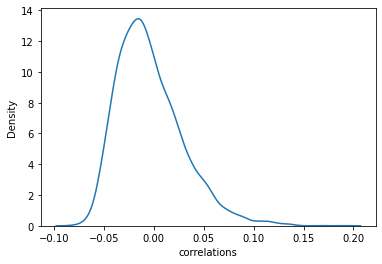

In [7]:
import matplotlib.pyplot as plt

sc.pp.neighbors(adata, n_neighbors=300)
adata.layers['X_knn'] = adata.obsp['connectivities'].dot(adata.X)
adata.layers['gene_score_knn'] = adata.obsp['connectivities'].dot(adata.obsm["gene_score"])
print(adata.layers['X_knn'].shape, adata.layers['gene_score_knn'].shape)
from scipy.stats import pearsonr
cors = []
for i in range(adata.layers['X_knn'].shape[0]):
    x = adata.layers['X_knn'][i,:]
    y = adata.layers['gene_score_knn'][i,:].toarray().flatten()
    cors.append(pearsonr(x, y))
cors_cor = list(map(lambda x: x[0], cors))
sns.kdeplot(np.array(list(cors_cor)))
plt.xlabel('correlations')

## RP-enhanced

In [8]:
# test = False does not work as tss_to_peaks need to be sub-sampled, and it seems that everything is blended.
adata = datasets.snare_p0_braincortex(test=False)
print('before filtering', adata.shape)
adata = adata[:, adata.var.index.isin(sel_genes)]
print('after filtering', adata.shape)


before filtering (5081, 19322)
after filtering (5081, 1234)


In [9]:
adata = methods.rp_enhanced(adata, n_top_genes=2000) #  log_each=10)

... storing 'chr' as categorical
... storing 'strand' as categorical
/home/icb/ignacio.ibarra/miniconda3/envs/openproblems/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


calculating weights per gene...
# weights calculated so far 500 out of 1232
# weights calculated so far 1000 out of 1232


In [10]:
%autoreload 2
import seaborn as sns
from openproblems.tasks.regulatory_effect_prediction import metrics
cors = metrics.spearman_correlation(adata), metrics.pearson_correlation(adata)
print(cors)

(0.010924862357515821, -0.010644082225420766)


         Falling back to preprocessing with `sc.pp.pca` and default params.


(5081, 1233) (5081, 1233)


Text(0.5, 0, 'correlations')

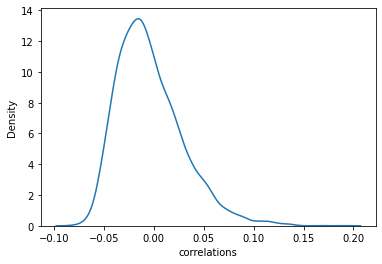

In [11]:
import matplotlib.pyplot as plt

sc.pp.neighbors(adata, n_neighbors=300)
adata.layers['X_knn'] = adata.obsp['connectivities'].dot(adata.X)
adata.layers['gene_score_knn'] = adata.obsp['connectivities'].dot(adata.obsm["gene_score"])
print(adata.layers['X_knn'].shape, adata.layers['gene_score_knn'].shape)
from scipy.stats import pearsonr
cors = []
for i in range(adata.layers['X_knn'].shape[0]):
    x = adata.layers['X_knn'][i,:]
    y = adata.layers['gene_score_knn'][i,:].toarray().flatten()
    cors.append(pearsonr(x, y))
cors_cor = list(map(lambda x: x[0], cors))
sns.kdeplot(np.array(list(cors_cor)))
plt.xlabel('correlations')